In [104]:
import asyncio
import websockets
import json
import pandas as pd
#import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()

import csv
from scipy import stats
import os

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
posn_path = os.path.join(os.getcwd(), "performance_analytics","positions.xlsx")
idx_path = os.path.join(os.getcwd(), "performance_analytics","eth_index.csv")
val_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\val.xlsx"

In [106]:
hdata = HistData('ETH')
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
eth_idx = hdata.get_hist_data(start_dt,end_dt,'ETH-PERPETUAL','1D')[['close']]
eth_idx.index = [dt.strftime('%Y-%m-%d') for dt in eth_idx.index]
eth_idx.index.names = ['Date']
eth_idx.to_csv(idx_path)
#eth_idx.to_csv(idx_path)

In [107]:
positions = pd.read_excel(posn_path,index_col = 0)
idx_px = pd.read_csv(idx_path,index_col = 0)
val = pd.read_excel(val_path,index_col = 0)

In [108]:
skeleton = pd.DataFrame()
indices = pd.date_range(datetime.datetime.fromtimestamp(start_dt/1000),pd.datetime.today())
indices = [dt.strftime("%Y-%m-%d") for dt in indices]
skeleton.index = indices

In [109]:
positions = pd.concat([skeleton,positions],axis = 1).fillna(method = 'ffill')
positions.to_excel(posn_path)

In [110]:
latest_val = val.iloc[-1][0]
#dep = int(input())
dep = latest_val
latest_val = pd.DataFrame([dep],index = [pd.datetime.today().date()],columns = ['val'])
#latest_val

In [111]:
start_dt = val.index[0]
skeleton = pd.DataFrame(index = pd.date_range(start_dt,pd.datetime.today()),columns = ['val'])
val = val.reindex_like(skeleton).fillna(method = 'ffill')
val.to_excel(val_path)

with open(val_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(latest_val)):
        temp = latest_val.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()


In [112]:
val = pd.read_excel(val_path,index_col = 0)
val

,val
2024-01-01,3000
2024-01-02,3000
2024-01-03,3000
2024-01-04,3000
2024-01-05,3000
...,...
2024-04-23,3000
2024-04-24,3000
2024-04-25,3000
2024-04-26,3000


In [113]:
idx_px.index.names,positions.index.names = ['Date'],['Date']

In [114]:
usd_rets = positions.join(idx_px,on='Date',how = 'left')
usd_rets['Tactical Beta Convexity'] = usd_rets['close'].diff()*usd_rets['positions']

In [115]:
usd_rets = usd_rets.dropna()
usd_rets.dropna()

,positions,close,Tactical Beta Convexity
Date,,,
2024-01-02,0.80000,2363.35,-22.240000
2024-01-03,0.80000,2224.55,-111.040000
2024-01-04,0.80000,2255.15,24.480000
2024-01-05,0.80000,2233.35,-17.440000
2024-01-06,0.80000,2250.25,13.520000
...,...,...,...
2024-04-22,0.83152,3157.85,-41.201816
2024-04-23,0.83152,3252.00,78.287608
2024-04-24,0.83152,3135.55,-96.830504


In [116]:
vol_float_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\floating_rets.csv"
vol_rel_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\realized_rets.csv"

In [117]:
vol_float_rets = pd.read_csv(vol_float_pnl_path,index_col = 0)
vol_rel_rets = pd.read_csv(vol_rel_pnl_path,index_col = 0)
vol_rel_rets = vol_rel_rets.groupby(vol_rel_rets.index).sum()
vol_rel_rets = vol_rel_rets[['PnL','txn_cost']]
#vol_rel_rets = vol_rel_rets['PnL']-vol_rel_rets['txn_cost']

In [118]:

#vol_float_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_float_rets.index,format = "%d/%m/%Y")]
#vol_rel_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rel_rets.index,format = "%Y-%m-%d")]

In [119]:
vol_rets = pd.DataFrame(pd.concat([vol_float_rets,vol_rel_rets[['PnL']]],axis=1).sum(axis=1),columns = ['Short Volatility'])
vol_rets = pd.concat([vol_rets,vol_rel_rets[['txn_cost']]],axis=1)
vol_rets.columns  = ['Short Volatility','Txn Cost']
vol_rets.fillna(0,inplace = True)
vol_rets = vol_rets.sort_index()

In [120]:
curr_px = usd_rets['close'].iloc[-1]
vol_rets = pd.concat([vol_rets,eth_idx],axis=1)#vol_rets*curr_px
vol_rets = vol_rets.sort_index().fillna(0)


In [121]:
vol_rets['Short Volatility'] = vol_rets['Short Volatility']* vol_rets['close']
vol_rets['Txn Cost'] = vol_rets['Txn Cost']* vol_rets['close']
vol_rets = vol_rets[['Short Volatility','Txn Cost']]

In [122]:
convexity = usd_rets[['Tactical Beta Convexity']]
convexity.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(convexity.index)]

In [123]:
vol_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rets.index)]

In [124]:
vol_rets

,Short Volatility,Txn Cost
2023-12-31,0.00000,0.00000
2024-01-01,0.00000,0.00000
2024-01-02,0.00000,0.00000
2024-01-03,0.00000,0.00000
2024-01-04,0.00000,0.00000
...,...,...
2024-04-23,24.24301,0.00000
2024-04-24,0.00000,0.00000
2024-04-25,0.00000,0.00000
2024-04-26,118.67210,7.49508


In [125]:
convexity.index

Index(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06',
       '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
       ...
       '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-20', '2024-04-21',
       '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26'],
      dtype='object', length=116)

In [126]:
usd_rets = pd.concat([convexity,vol_rets],axis=1).fillna(0)
usd_rets

,Tactical Beta Convexity,Short Volatility,Txn Cost
2024-01-02,-22.240000,0.0000,0.00000
2024-01-03,-111.040000,0.0000,0.00000
2024-01-04,24.480000,0.0000,0.00000
2024-01-05,-17.440000,0.0000,0.00000
2024-01-06,13.520000,0.0000,0.00000
...,...,...,...
2024-04-25,-2.536136,0.0000,0.00000
2024-04-26,-7.941016,118.6721,7.49508
2023-12-31,0.000000,0.0000,0.00000
2024-01-01,0.000000,0.0000,0.00000


In [127]:

usd_rets['Total (Cost Adjusted)'] = usd_rets['Tactical Beta Convexity']+usd_rets['Short Volatility']-usd_rets['Txn Cost']
usd_rets.index.names = ["Date"]

In [128]:
usd_rets = pd.concat([usd_rets,eth_idx.diff()],axis=1).sort_index().iloc[2:]

In [129]:
usd_rets

,Tactical Beta Convexity,Short Volatility,Txn Cost,Total (Cost Adjusted),close
Date,,,,,
2024-01-02,-22.240000,0.00000,0.00000,-22.240000,-27.80
2024-01-03,-111.040000,0.00000,0.00000,-111.040000,-138.80
2024-01-04,24.480000,0.00000,0.00000,24.480000,30.60
2024-01-05,-17.440000,0.00000,0.00000,-17.440000,-21.80
2024-01-06,13.520000,0.00000,0.00000,13.520000,16.90
...,...,...,...,...,...
2024-04-23,78.287608,24.24301,0.00000,102.530618,94.15
2024-04-24,-96.830504,0.00000,0.00000,-96.830504,-116.45
2024-04-25,-2.536136,0.00000,0.00000,-2.536136,-3.05


<Axes: xlabel='Date'>

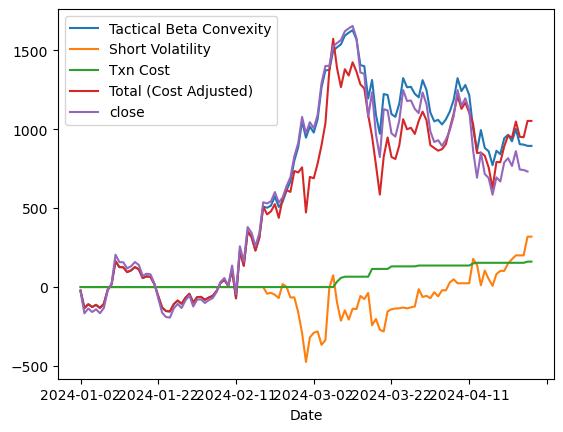

In [130]:
usd_rets.cumsum().plot()

In [131]:
usd_rets = ((usd_rets/3000).cumsum()    )

val.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(val.index)]
vals = pd.concat([usd_rets,val],axis=1)['val']
usd_rets = pd.concat([usd_rets.cumsum(),val],axis=1).dropna()
for col in usd_rets.columns:
    usd_rets[col]=usd_rets[col]+usd_rets['val']

usd_rets.index = pd.to_datetime(usd_rets.index)
usd_rets = usd_rets[['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Txn Cost']]
eth_idx.index = pd.to_datetime(eth_idx.index)
usd_rets = pd.concat([usd_rets,eth_idx],axis=1).fillna(method = 'ffill')
usd_rets.columns = ['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Cost','Index']
usd_rets = usd_rets[['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Index']]

In [132]:
usd_rets = usd_rets[['Total (Cost Adjusted)','Tactical Beta Convexity', 'Short Volatility','close','Txn Cost']]
usd_rets.columns = ['Total (Cost Adjusted)','Tactical Beta Convexity', 'Short Volatility','Index','Txn Cost']

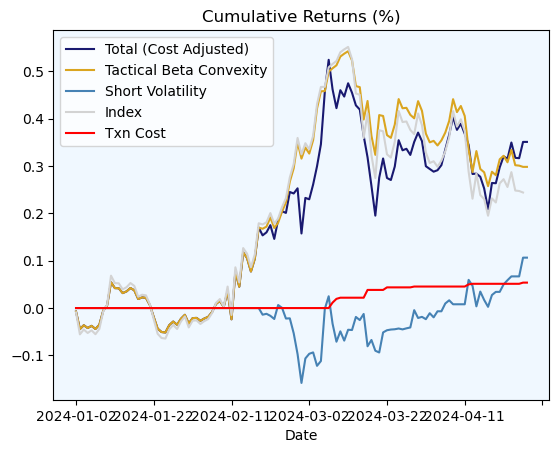

In [133]:
plot = usd_rets.plot(title = 'Cumulative Returns (%)',color = ['midnightblue','goldenrod','steelblue','lightgrey','red'])
#(((1+eth_idx.pct_change()).cumprod()-1)*100).plot()
plot.set_facecolor('aliceblue')
picpath = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\MasterFundPerformance.png"
plot.get_figure().savefig(picpath)

In [134]:
rets = usd_rets[['Total (Cost Adjusted)']].diff().fillna(0)

In [135]:
np.sqrt(252)* rets.mean()/rets.std()

Total (Cost Adjusted)    1.414247
dtype: float64

<Axes: title={'center': 'Master Fund Expanding-Window Sharpe Ratio'}, xlabel='Date'>

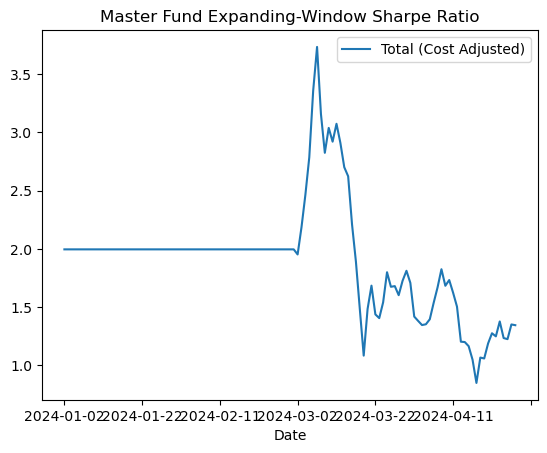

In [136]:
(np.sqrt(252)* (rets.expanding(60).mean()-0.053/350)/rets.expanding().std()).fillna(method = 'bfill').plot(title = 'Master Fund Expanding-Window Sharpe Ratio')